In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from helpers import util
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
# This line will fail if you have not registered the AQICN_API_KEY as a secret in Hopsworks
AQICN_API_KEY = secrets.get_secret("AQICN_API_KEY").value
sensors_str = secrets.get_secret("SENSORS_JSON").value
sensors_data = json.loads(sensors_str)

2025-11-17 14:30:11,938 INFO: Initializing external client
2025-11-17 14:30:11,939 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-17 14:30:13,420 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1272018


In [3]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [4]:
# Select features for training data. todo check if city should be here
models = ["base", "lagged"]

features = {}
features['base'] = air_quality_fg.select(['pm25', 'city', 'date']).join(weather_fg.select_features(), on=['city'])
features['lagged'] = air_quality_fg.select(['pm25', 'lagged_1', 'lagged_2', 'lagged_3', 'city', 'date']).join(weather_fg.select_features(), on=['city'])

2025-11-17 14:30:16,583 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] as features for the query.To include primary key and event time use `select_all`.
2025-11-17 14:30:16,584 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] as features for the query.To include primary key and event time use `select_all`.


In [5]:
feature_views = {}

for model in models:
    feature_views[model] = fs.get_or_create_feature_view(
        name=f"air_quality_{model}_fv",
        description="weather features with air quality as the target",
        version=1,
        labels=['pm25'],
        query=features[model],
    )

In [6]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [7]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}

for model in models:
    x_tr, x_te, y_tr, y_te = feature_views[model].train_test_split(
        test_start=test_start
    )
    X_train[model] = x_tr
    X_test[model] = x_te
    y_train[model] = y_tr
    y_test[model] = y_te

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.50s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.25s) 


In [8]:
X_features = {}
X_test_features = {}

for model in models:
    X_train[model]['city'] = X_train[model]['city'].astype("category")
    X_test[model]['city'] = X_test[model]['city'].astype("category")
    X_features[model] = X_train[model].drop(columns=['date'])
    X_test_features[model] = X_test[model].drop(columns=['date'])

In [9]:
X_train['base'].sort_values(by="date", ascending=False).head(40)

,city,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
5925,årjäng,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
3014,jonsbyn,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
3813,skoghall,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
1214,nykroppa,2025-04-30 00:00:00+00:00,10.469500,0.0,20.633371,320.021698
1213,nykroppa,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
3013,jonsbyn,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
3812,skoghall,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
5924,årjäng,2025-04-29 00:00:00+00:00,12.359082,0.0,19.060459,294.809357
1212,nykroppa,2025-04-28 00:00:00+00:00,10.779916,0.5,32.442471,242.646667
3012,jonsbyn,2025-04-28 00:00:00+00:00,10.779916,0.5,32.442471,242.646667


In [10]:
xgb_regressors = {}

for model in models:
    xgb_regressors[model] = XGBRegressor(enable_categorical=True, tree_method="hist")
    # Fitting the XGBoost Regressor to the training data
    xgb_regressors[model].fit(X_features[model], y_train[model])


In [11]:
y_pred_train = {}
y_pred_test = {}
mse_train = {}
mse_test = {}
r2_train = {}
r2_test = {}

for model in models:
    # Predicting target values on the train set
    y_pred_train[model] = xgb_regressors[model].predict(X_features[model])
    # Predicting target values on the test set
    y_pred_test[model] = xgb_regressors[model].predict(X_test_features[model])
    # Calculating Mean Squared Error (MSE) using sklearn
    mse_train[model] = mean_squared_error(y_train[model].iloc[:,0], y_pred_train[model])
    mse_test[model] = mean_squared_error(y_test[model].iloc[:,0], y_pred_test[model])
    # Calculating R squared using sklearn
    r2_train[model] = r2_score(y_train[model].iloc[:,0], y_pred_train[model])
    r2_test[model] = r2_score(y_test[model].iloc[:,0], y_pred_test[model])

In [12]:
df = {}

for model in models:
    df[model] = y_test[model]
    df[model]['city'] = X_test[model]['city']
    df[model]['date'] = X_test[model]['date']
    df[model]['predicted_pm25'] = y_pred_test[model]

In [13]:
df['base']

,pm25,city,date,predicted_pm25
1215,6.720,nykroppa,2025-05-01 00:00:00+00:00,9.133824
1216,4.536,nykroppa,2025-05-02 00:00:00+00:00,3.110016
1217,1.680,nykroppa,2025-05-03 00:00:00+00:00,6.041171
1218,3.360,nykroppa,2025-05-04 00:00:00+00:00,-1.506394
1219,2.940,nykroppa,2025-05-05 00:00:00+00:00,5.733379
...,...,...,...,...
6122,0.000,årjäng,2025-11-13 00:00:00+00:00,3.468812
6123,2.000,årjäng,2025-11-14 00:00:00+00:00,2.604430
6124,2.000,årjäng,2025-11-15 00:00:00+00:00,6.914410
6125,2.000,årjäng,2025-11-16 00:00:00+00:00,3.838972


In [14]:
# Creating a directory for the model artifacts if it doesn't exist
docs_folder = "docs"
if not os.path.exists(docs_folder):
    os.mkdir(docs_folder)
    
base_folder = docs_folder + "/air_quality"
if not os.path.exists(base_folder):
    os.mkdir(base_folder)

model_dir = {}
images_dir = {}

for model in models:
    model_dir[model] = base_folder + f"/{model}"
    if not os.path.exists(model_dir[model]):
        os.mkdir(model_dir[model])
    images_dir[model] = model_dir[model] + '/images'
    if not os.path.exists(images_dir[model]):
        os.mkdir(images_dir[model])

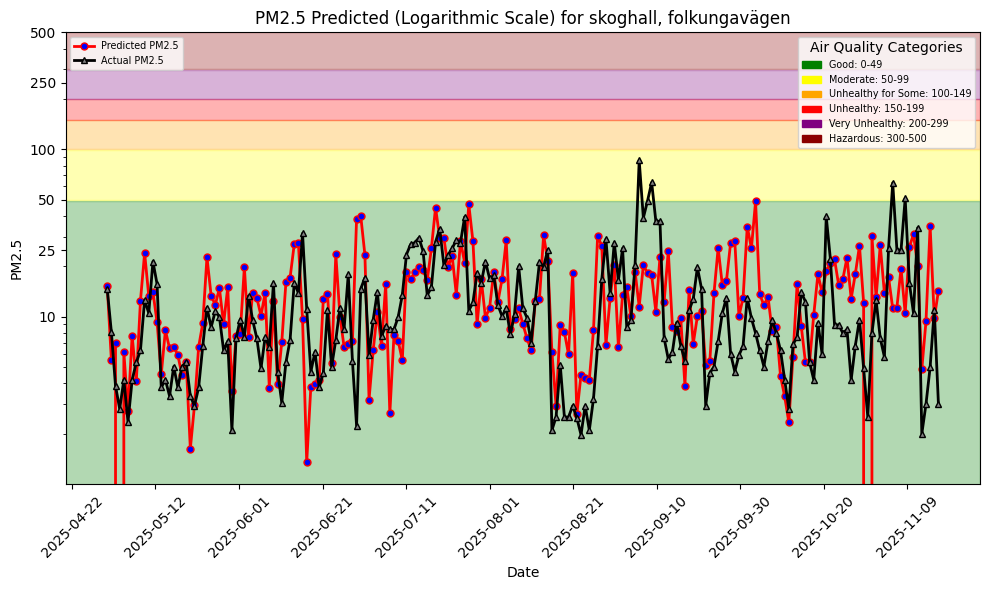

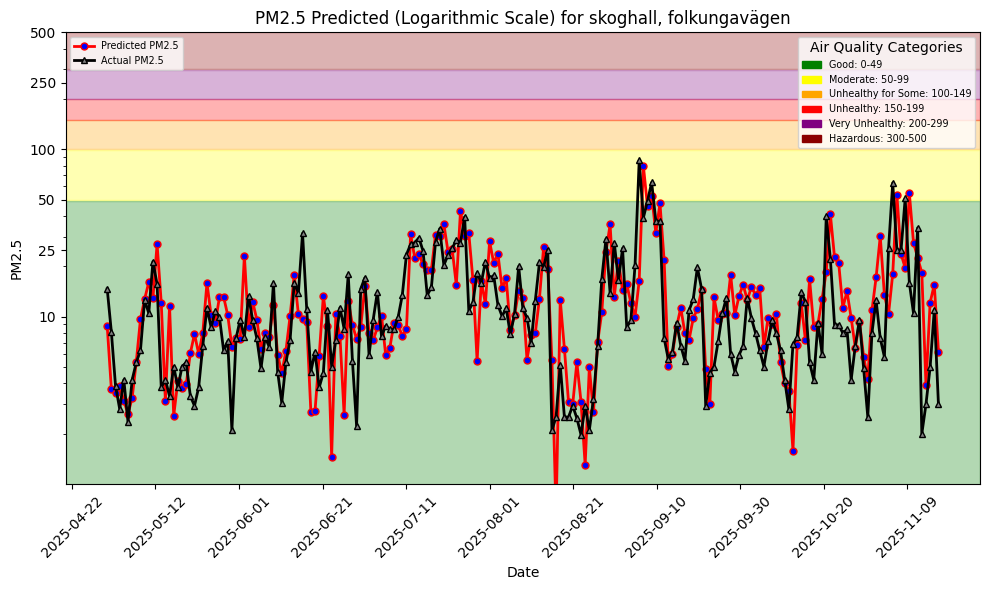

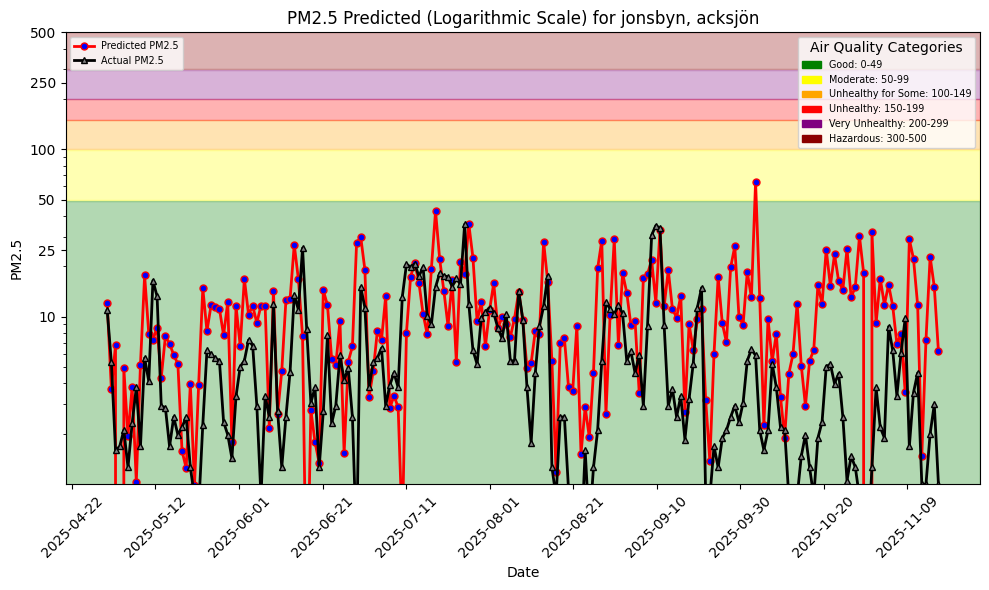

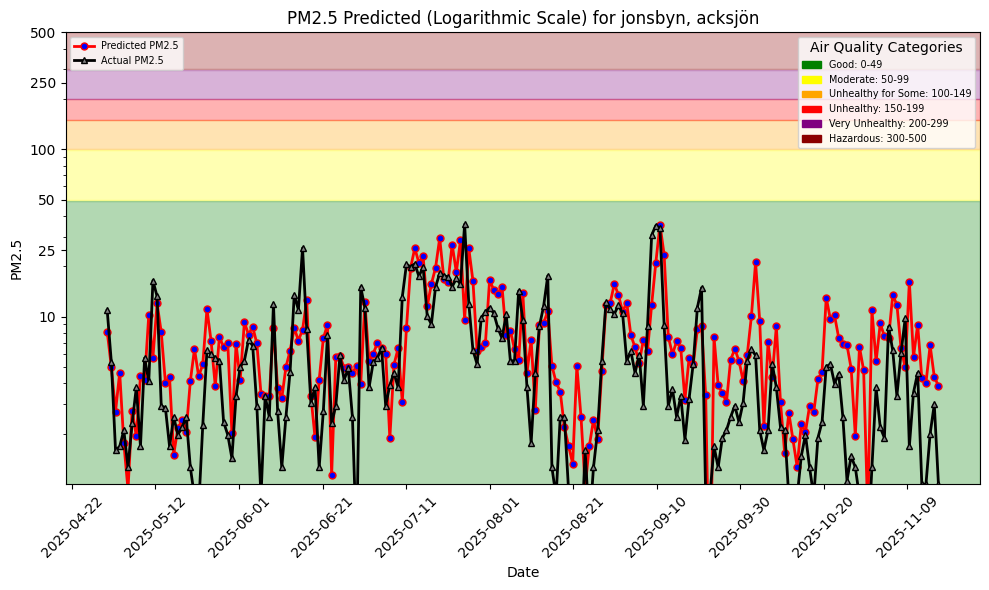

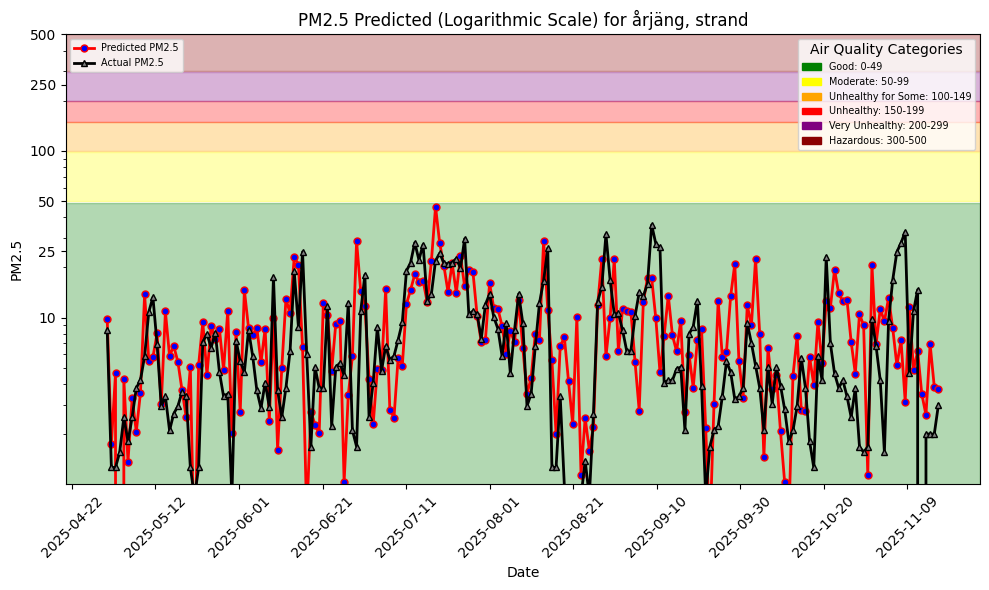

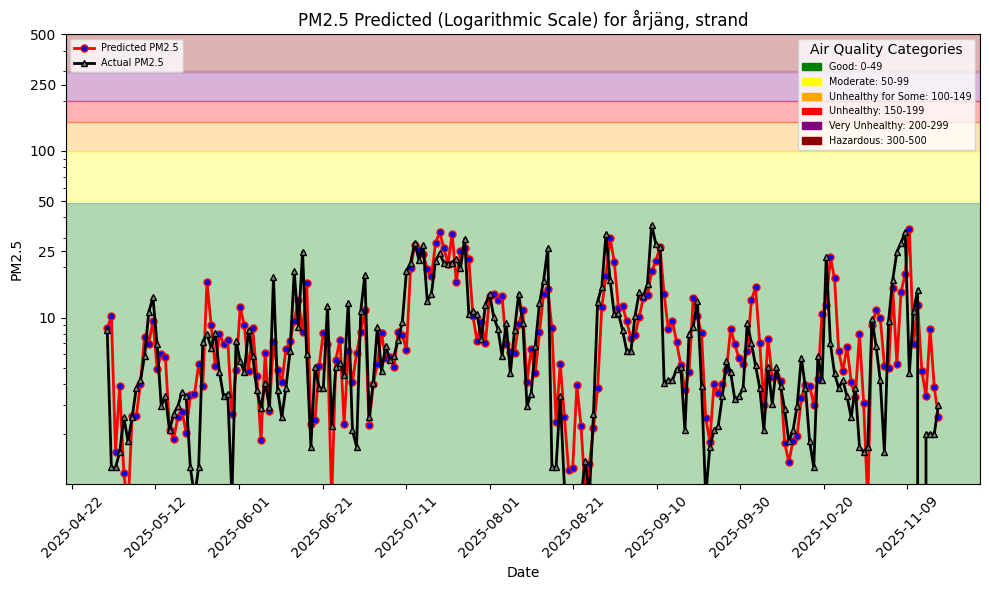

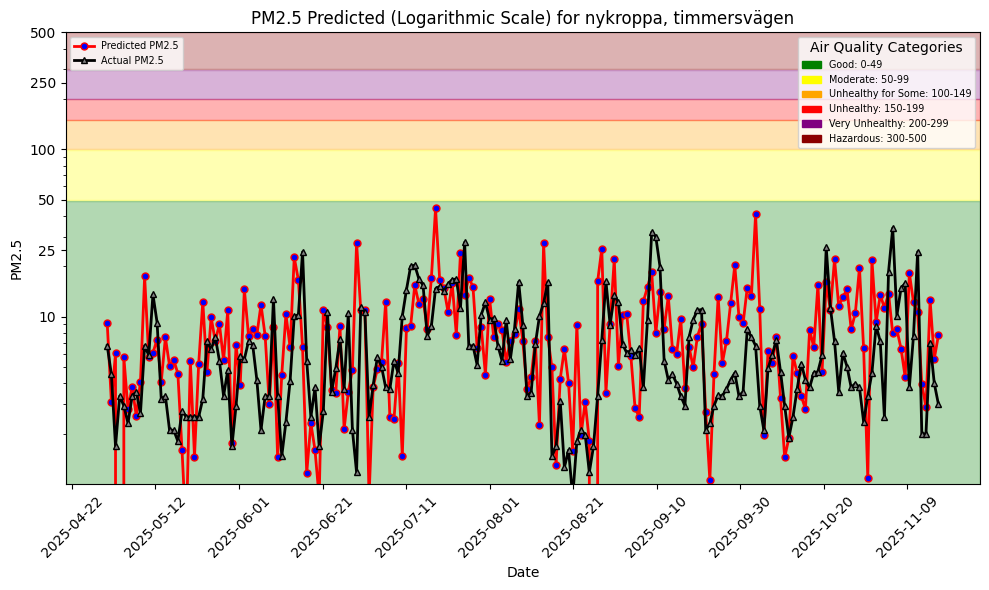

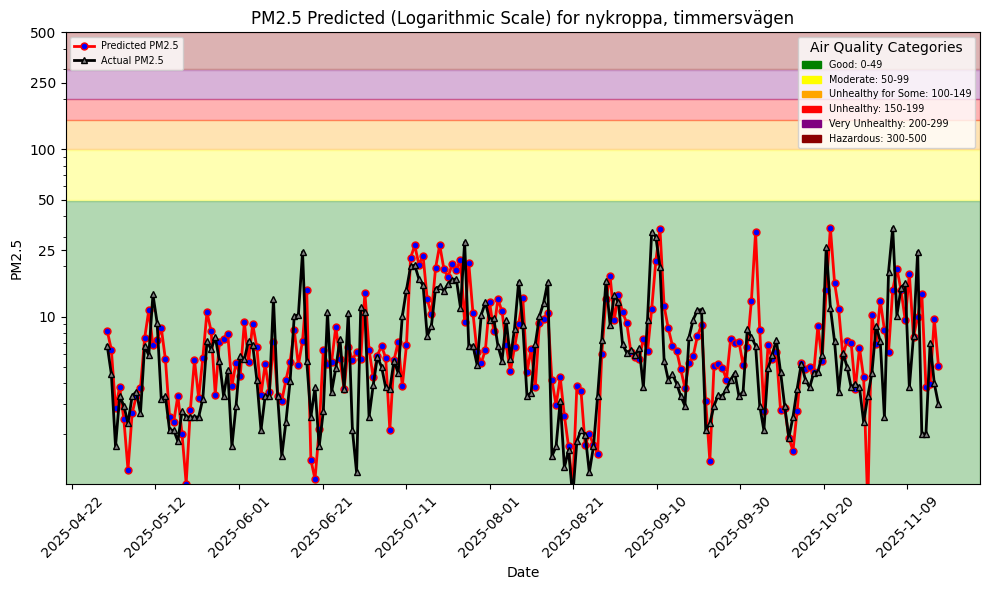

In [15]:
for location in sensors_data:
    city = location['city']
    street = location['street']
    city_dir = {}
    file_path = {}
    plots = {}
    for model in models:
        city_dir[model] = f"{images_dir[model]}/{city}"
        if not os.path.exists(city_dir[model]):
            os.mkdir(city_dir[model])
        file_path[model] = f"{city_dir[model]}/pm25_trainset_hindcast.png"
        plots[model] = util.plot_air_quality_forecast(city, street, df[model][df[model]['city'] == city], file_path[model], hindcast=True) 
        plots[model].show()

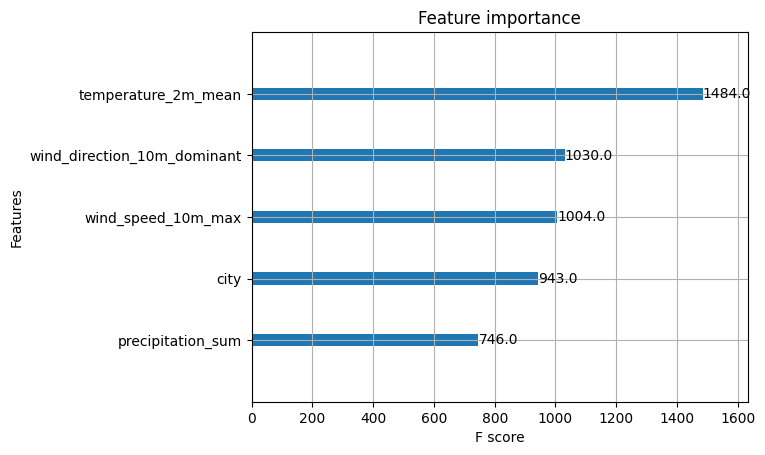

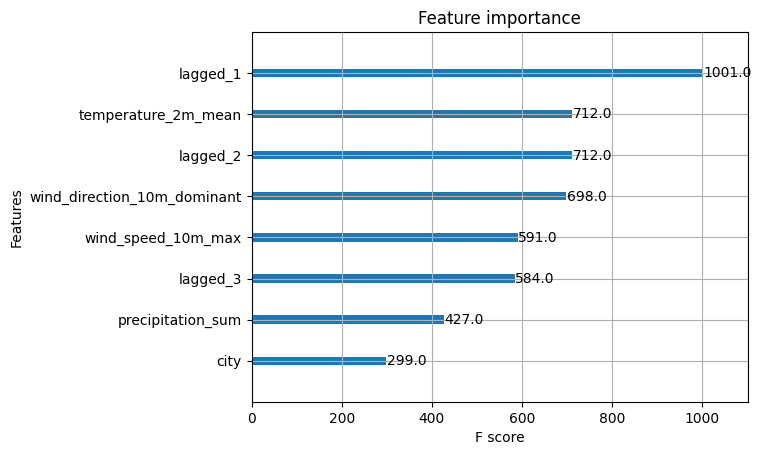

In [16]:
# Plotting feature importances using the plot_importance function from XGBoost
feature_importance_path = {}

for model in models:
    plot_importance(xgb_regressors[model])
    feature_importance_path[model] = images_dir[model] + "/feature_importance.png"
    plt.savefig(feature_importance_path[model])
    plt.show

In [17]:
# Saving the XGBoost regressor object as a json file in the model directory
for model in models:
    xgb_regressors[model].save_model(model_dir[model] + "/model.json")

In [18]:
res_dict = {}

for model in models:
    res_dict[model] = {
        "MSE": str(mse_test[model]),
        "R squared": str(r2_test[model]),
    }

In [19]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = {}

for model in models:
    aq_model[model] = mr.python.create_model(
        name=f"air_quality_xgboost_{model}_model", 
        metrics= res_dict[model],
        feature_view=feature_views[model],
        description="Air Quality (PM2.5) predictor",
    )
    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model[model].save(model_dir[model])

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/597287 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/21760 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/147860 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/146760 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/143382 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/151583 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272018/models/air_quality_xgboost_base_model/7


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/568872 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/27730 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/138439 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/139492 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/139747 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/139972 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272018/models/air_quality_xgboost_lagged_model/7
